In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import json
import time
from datetime import datetime
import numpy as np
from IPython.display import display, Markdown, IFrame
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns
%matplotlib inline


In [32]:
lineage_order = ["driver::send", 
                     "clipper::frontend_rpc_recv", 
                     "clipper::task_enqueued", 
                     "clipper::task_dequeued", 
                     "clipper::sent_rpc", 
                     "container::recv",
                     "container::send", 
                     "clipper::rpc_recv", 
                     "clipper::task_executor_recv",
                     "clipper::task_executor_recv_end",
                     "clipper::task_executor_msg_callback_found",
                     "clipper::zmq_frontend_response_callback", 
                     "clipper::frontend_rpc_response_send", 
                     "driver::recv"]

def extract_lineage_deltas(lineage):
    first_key = "driver::send"

    extracted = {k: [] for k in lineage_order}
    for entry in lineage:
        for i in range(1,len(lineage_order)):
            try:
                k = lineage_order[i]
            
                previous_timestamp = entry[lineage_order[i-1]]
            
                delta = entry[k] - previous_timestamp
                extracted[k].append(float(delta) / 1000.0)
            except KeyError as e:
                print("CCCCCCCCCCCCCCCCCCC")
    return extracted



def plot_comparison(path, gpu_index):

    snp_lineages = {}
    for fpath in os.listdir(path):
        core = int(fpath.split("-")[gpu_index])
        with open(os.path.join(path, fpath), "r") as f:
            results = json.load(f)
            snp_lineages[core] = results["throughput_results"]["lineage"][1000:]

    snp_deltas = {core : extract_lineage_deltas(l) for core, l in snp_lineages.items()}
    deltas = snp_deltas
    colors = sns.color_palette("cubehelix", 16)
    point = "container::send"
#     fig, (ax_scatter, ax_hist, ax_box) = plt.subplots(ncols=3, figsize=(20,6))
    fig, ax_box = plt.subplots(ncols=1, figsize=(10,6))

    dists = []
    for core in range(len(snp_deltas)):
        extracted_lineage = deltas[core]
        print(core)
        v = extracted_lineage[point]
        if len(v) > 0:
            print(np.mean(v), np.percentile(v, 99))
#             ax_scatter.scatter(np.arange(len(v)), v, alpha = 0.4, label=str(core), color=colors[core])
#             ax_hist.hist(v, 100, label=str(core), normed=True, histtype='bar', color=colors[core], cumulative=False, log=True)
            dists.append(v)
    ax_box.boxplot(x=dists, positions=range(len(dists)), vert=True)
    ax_box.set_ylabel("Time (ms)")
    ax_box.set_xlabel("GPU number")
#     ax_scatter.set_ylabel("Time (ms)")
#     ax_scatter.legend(loc=0, ncol=4, mode="expand")
#     ax_hist.legend(loc=0)   
#     xmax = ax_hist.get_xlim()[1]
#     ax_hist.set_xlim(right=max(10, xmax))
#     ax_hist.set_xlabel("Time (ms)")
#     ax_hist.set_ylabel("Query ID")
#     ax_hist.set_ylabel("Count (normalized)")
#     ax_hist.grid(b=True, which="both")
    #         ax_box.legend(loc=0)
    fig.suptitle(point, fontsize=20)
    plt.savefig("gpu_assignment.pdf")
    plt.show()

# p3.8xlarge: No disparity in perf between GPUs

0
255.191821008 270.013
1
255.229464279 261.266
2
256.090291466 266.581
3
255.110720114 265.893


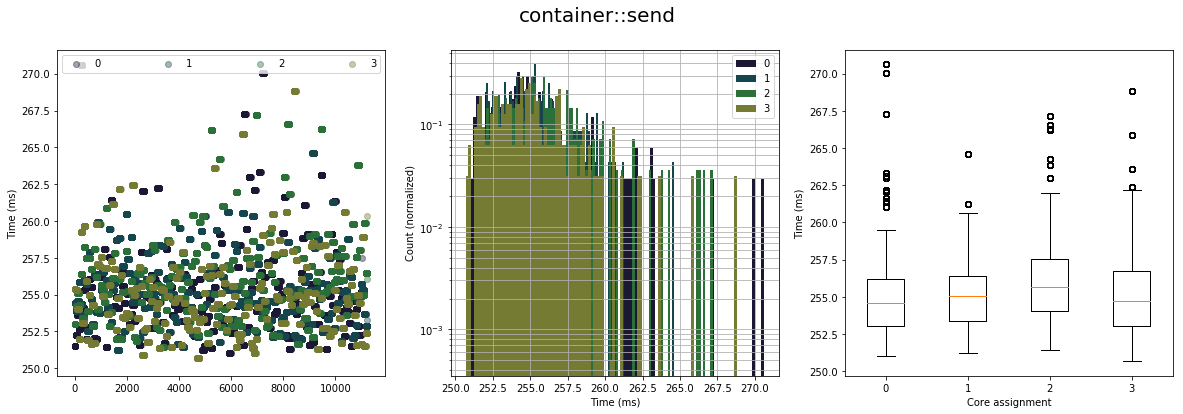

In [38]:
path = "../results_cpp_benchmarker/query_lineage/tf-resnet-feats-snp-resource-placement-debugging-gpu-v100-batch-64/"
plot_comparison(path, 7)

# p2.8xlarge: Even numbered GPUs are significantly faster

0
639.7139002 649.146
1
664.386538064 673.728
2
648.2486975 657.351
3
663.902946257 674.437
4
647.494788584 657.85
5
670.48636248 680.053
6
647.590282762 658.289
7
677.240180986 688.824


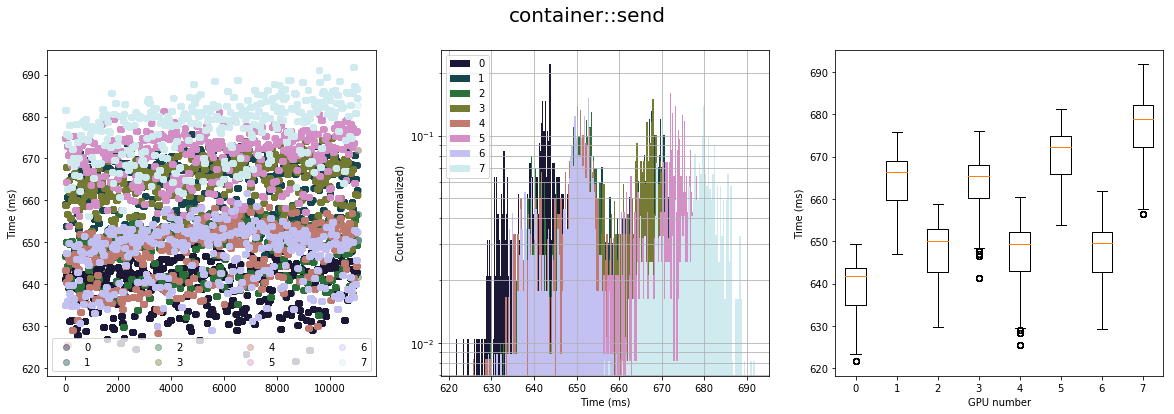

In [42]:
path = "../results_cpp_benchmarker/query_lineage/tf-resnet-feats-snp-resource-placement-debugging-gpu-k80-batch-32/"
plot_comparison(path, 7)

# p2.8xlarge: replication on new machine

0
646.935763679 655.081
1
663.633845574 673.735
2
642.963381004 651.019
3
664.85842505 674.735
4
645.474902846 655.21
5
667.456493274 677.265
6
648.765967279 657.316
7
666.265048628 676.456


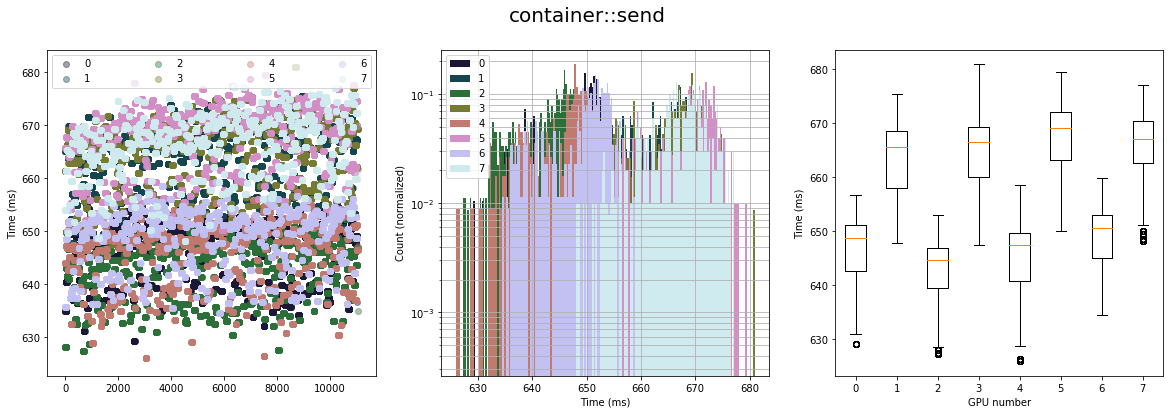

In [43]:
path = "../results_cpp_benchmarker/query_lineage/tf-resnet-feats-snp-resource-placement-debugging-gpu-k80-batch-32-machine2"
plot_comparison(path, 7)

# p2.8xlarge on dedicated host

0
637.574055626 646.86
1
654.417987457 663.197
2
644.83678922 655.204
3
656.6209971 665.982
4
639.703020029 649.128
5
651.004069784 660.07
6
641.755507908 650.906
7
664.303497462 673.004


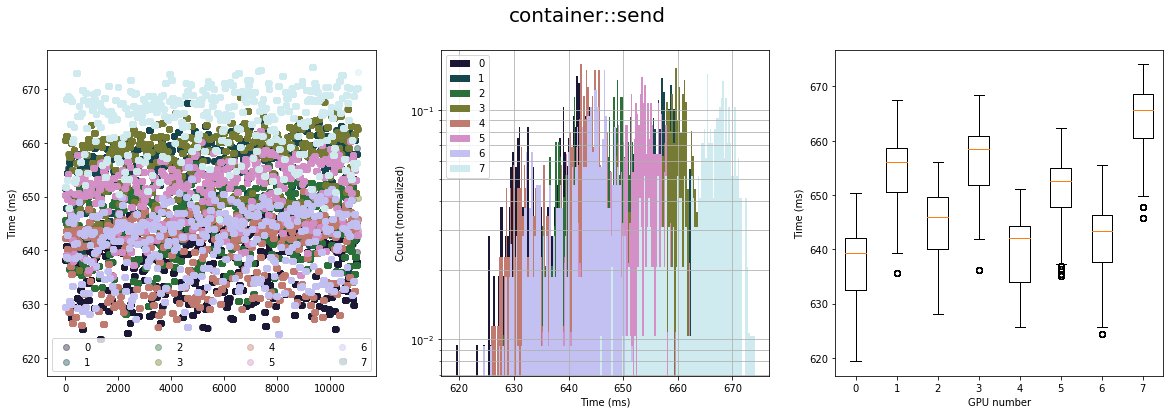

In [7]:
path = "../results_cpp_benchmarker/query_lineage/tf-resnet-feats-snp-gpu-placement-k80-batch-32-dedicated-tenancy"
plot_comparison(path, 7)

# p2.8xlarge Resnet50

0
349.097545527 355.001
1
357.247324023 365.004
2
356.45236311 364.516
3
358.135910793 367.082
4
351.642367884 364.846
5
363.137114585 381.427
6
359.207455739 374.966
7
361.596213372 375.143


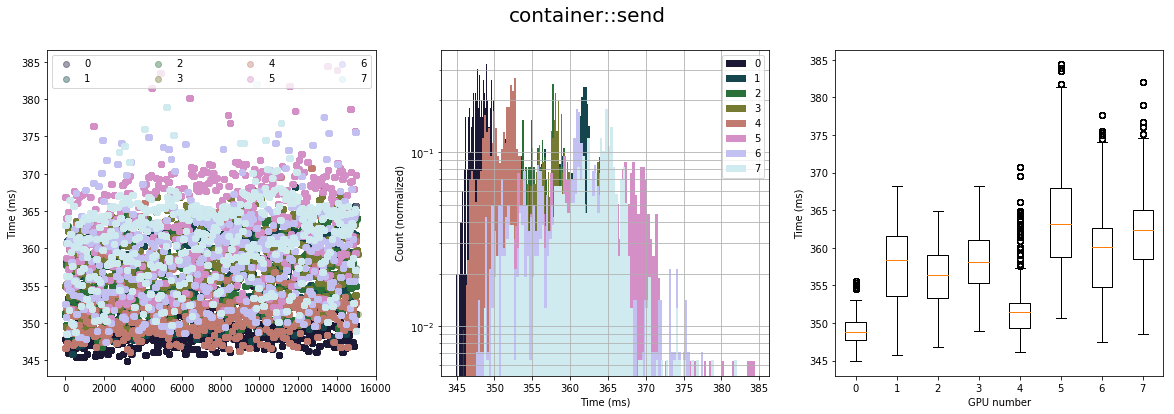

In [12]:
path = "../results_cpp_benchmarker/query_lineage/gpu-placement-discrepancy-res50"
plot_comparison(path, 8)

# NUMA on p2.8xlarge

```
ubuntu@ip-172-30-0-164:~$ numactl --hardware
available: 1 nodes (0)
node 0 cpus: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
node 0 size: 491806 MB
node 0 free: 490290 MB
node distances:
node   0
  0:  10
ubuntu@ip-172-30-0-164:~$ lscpu
Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                32
On-line CPU(s) list:   0-31
Thread(s) per core:    2
Core(s) per socket:    16
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
Stepping:              1
CPU MHz:               2698.277
CPU max MHz:           3000.0000
CPU min MHz:           1200.0000
BogoMIPS:              4600.06
Hypervisor vendor:     Xen
Virtualization type:   full
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              46080K
NUMA node0 CPU(s):     0-31
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc aperfmperf eagerfpu pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single retpoline kaiser fsgsbase bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx xsaveopt
```

In [8]:
display(Markdown("# Output of hwloc-ls"))
IFrame("p2.8xlarge-hwloc-ls.pdf", width=900, height=700)

# Output of hwloc-ls

# p2.8xlarge

# tf-resnet-feats

0
639.831254299 648.387
1
659.155800627 669.815
2
657.193845954 667.802
3
661.535338688 671.052
4
643.880527796 652.238
5
668.430913545 678.504
6
657.54079796 667.044
7
666.163111252 676.667


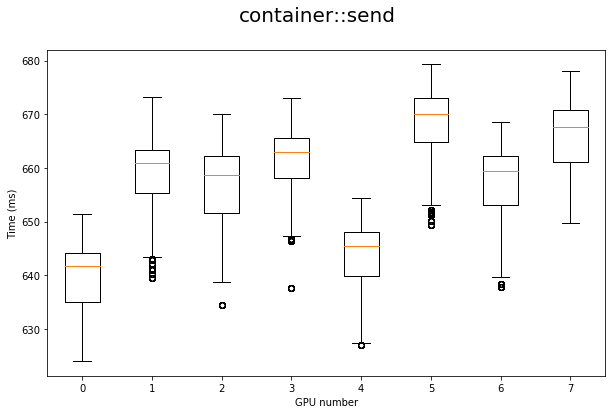

# res50

0
349.097545527 355.001
1
357.247324023 365.004
2
356.45236311 364.516
3
358.135910793 367.082
4
351.642367884 364.846
5
363.137114585 381.427
6
359.207455739 374.966
7
361.596213372 375.143


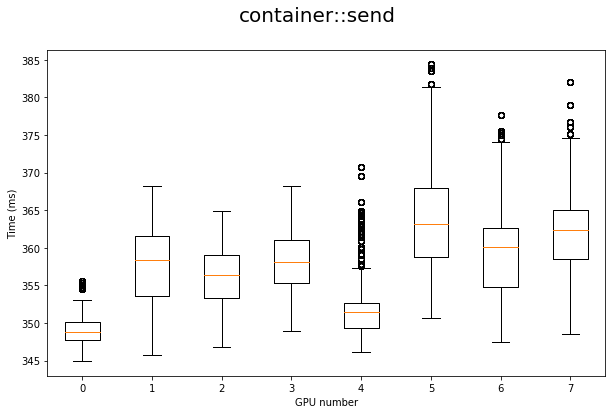

# inception

0
401.832900173 408.11
1
410.911500267 419.151
2
407.975864795 418.047
3
411.277282162 418.921
4
401.343993867 407.915
5
415.323735962 423.708
6
407.888403818 416.806
7
411.838971997 420.02


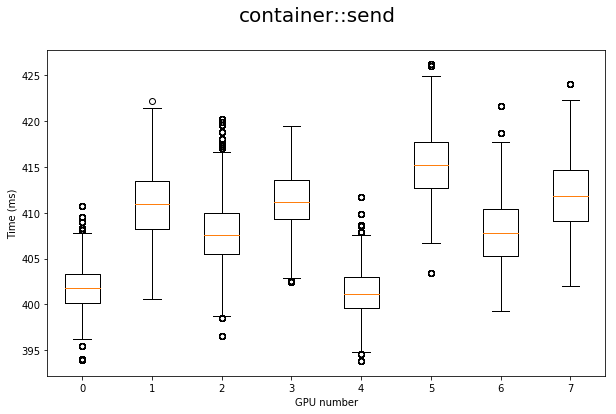

# alexnet

0
171.181641435 184.613
1
167.909822802 175.133
2
169.7135361 185.213
3
167.973701175 183.788
4
165.028539568 165.778
5
167.35891875 180.959
6
165.166957879 166.007
7
168.015231477 170.053


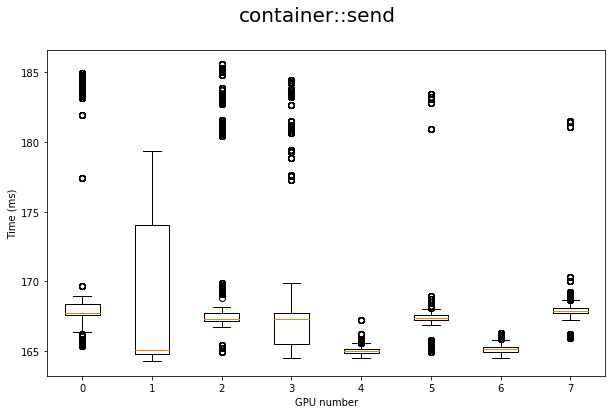

# res152

0
704.652045031 715.957
1
734.435029796 746.578
2
725.97717391 739.231
3
735.186455873 745.64
4
704.902744434 718.69
5
744.894725622 755.029
6
730.77597467 742.233
7
740.05090169 752.899


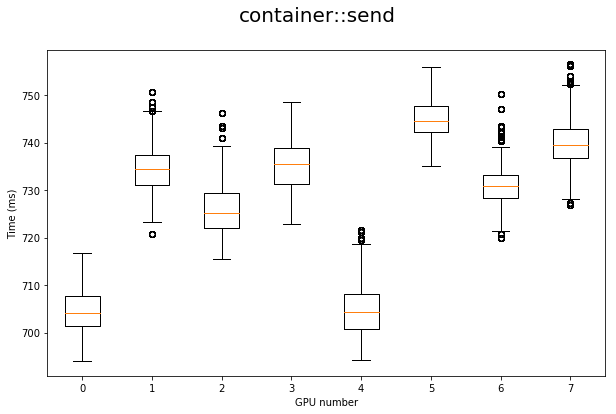

In [33]:
path = "../results_cpp_benchmarker/query_lineage/"
for d in os.listdir(path):
    if "gpu-placement-discrepancy" in d:
        model = "-".join(d.split("-")[3:])
        display(Markdown("# {}".format(model)))
        idx = 8
        if model == "tf-resnet-feats":
            idx = 10
        plot_comparison(os.path.join(path, d), idx)
        

# p2.16xlarge

# alexnet

0
170.417580686 184.26
1
169.330327875 179.73
2
170.285120621 184.144
3
168.746697651 180.25
4
171.613990522 186.357
5
170.475902689 185.158
6
167.200680116 172.292
7
172.340164124 185.951
8
168.908715833 184.23
9
167.882895658 177.874
10
169.702332583 179.592
11
171.177377316 185.26
12
170.050050072 183.391
13
169.852527464 181.598
14
170.195729078 185.674
15
168.649753984 184.118


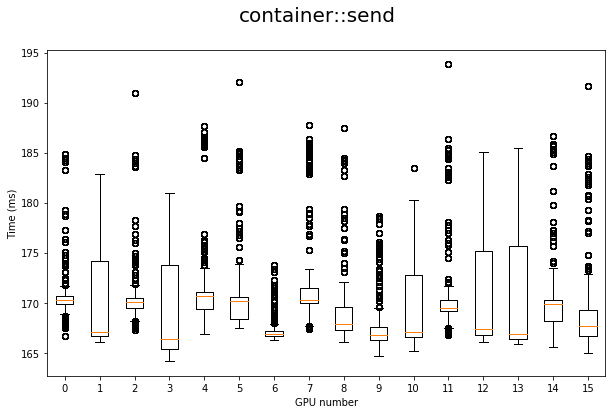

# res50

0
351.251554811 365.569
1
366.563219058 383.112
2
352.620198954 365.11
3
363.115610475 378.92
4
353.243134341 368.384
5
363.841808568 377.071
6
349.140030918 357.128
7
359.74308426 374.745
8
352.955838893 360.59
9
363.183790062 380.13
10
353.967019412 363.546
11
363.565215059 373.7
12
354.898448683 370.892
13
362.981170068 373.791
14
355.291547016 371.713
15
362.410725739 372.868


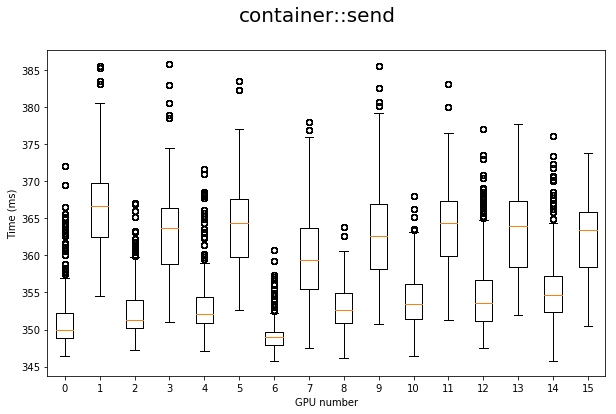

# res152

0
707.599379295 733.592
1
754.960196873 774.913
2
709.846195668 730.437
3
746.502790375 769.249
4
712.702437064 734.711
5
750.799756681 771.809
6
702.386936832 729.01
7
741.811097164 762.207
8
713.138739229 728.754
9
744.930714143 757.261
10
720.755446282 738.295
11
750.112231503 769.888
12
715.716004817 736.855
13
752.449252136 767.657
14
716.386373935 737.452
15
749.39333424 766.099


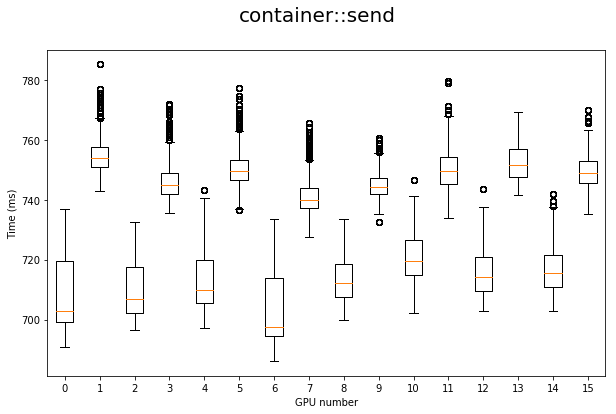

# inception

0
454.985634339 488.43
1
454.925700018 479.76
2
426.623124162 445.41
3
436.875217328 452.001
4
417.897562534 433.493
5
439.916142247 455.95
6
424.119717233 438.94
7
432.353747967 448.311
8
418.025696755 432.308
9
429.342937376 443.829
10
418.908773812 430.247
11
430.64755338 446.899
12
414.932084894 427.49
13
426.767392242 441.336
14
415.983688784 428.3
15
425.646428403 439.474


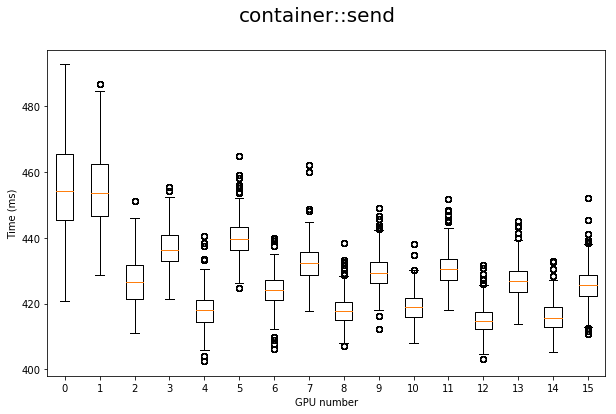

# tf-resnet-feats

0
646.57243283 657.658
1
680.534911834 691.599
2
647.979328167 659.141
3
672.390126699 684.331
4
651.668284766 663.388
5
673.401001636 685.481
6
644.253968551 656.62
7
665.171708508 677.381
8
648.654284484 658.887
9
667.773318669 679.282
10
649.608600891 660.882
11
668.034577895 678.892
12
644.834344481 655.471
13
670.541597891 683.111
14
646.546971096 657.004
15
670.516411107 682.357


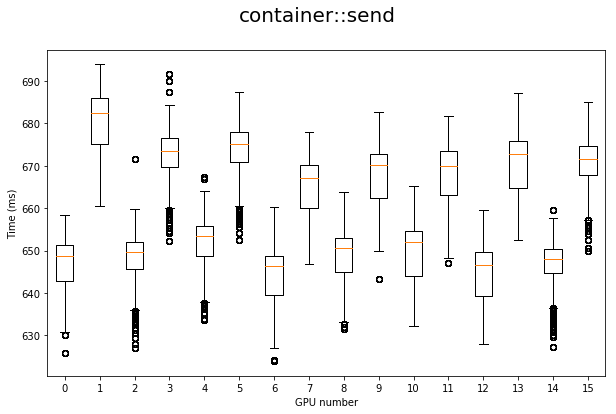

In [36]:
path = "../results_cpp_benchmarker/query_lineage/16x_large_gpu_placement"
for d in os.listdir(path):
    model = d.split("-gpu-placement")[0]
    display(Markdown("# {}".format(model)))
    idx = 5
    if model == "tf-resnet-feats":
        idx = 7
    plot_comparison(os.path.join(path, d), idx)
        